In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!unzip -uq "/content/drive/MyDrive/HACKATHON 2020/Transfer Learning (without Data Augmentation)/spectrograms.zip" -d "/content/drive/MyDrive/HACKATHON 2020/Transfer Learning (without Data Augmentation)"

In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_height, img_width, channels = 447, 447, 3
BATCH_SIZE = 64 
IMG_SIZE = (img_height, img_width)

train_dir = '/content/drive/MyDrive/HACKATHON 2020/Transfer Learning (without Data Augmentation)/train/'
validation_dir = '/content/drive/MyDrive/HACKATHON 2020/Transfer Learning (without Data Augmentation)/test/'

In [41]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1717 files belonging to 2 classes.
Found 744 files belonging to 2 classes.


In [42]:
neg = 1616 + 693
pos = 101 + 51
total = pos + neg 

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 2461
    Positive: 152 (6.18% of total)

Weight for class 0: 0.53
Weight for class 1: 8.10


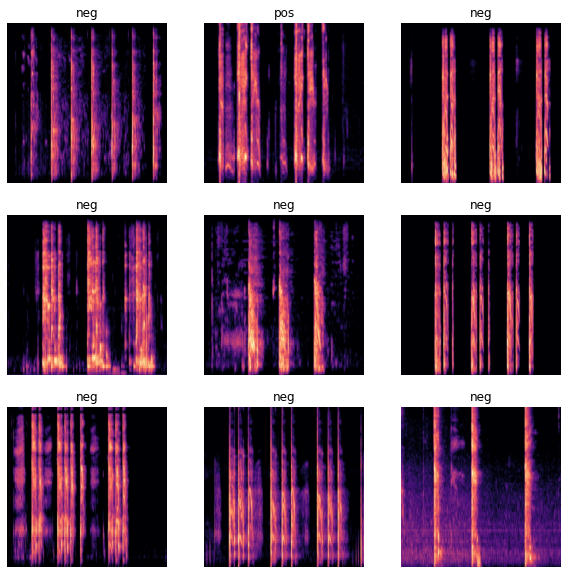

In [ ]:
class_names = train_dataset.class_names
len(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [43]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 6


In [ ]:
import numpy as np

size = 0
pos_size = 0
neg_size = 0
for i in range(tf.data.experimental.cardinality(test_dataset).numpy()):
  batch_labels = list(test_dataset.as_numpy_iterator())[i][1]
  positives = np.count_nonzero(batch_labels)
  negatives = len(batch_labels) - positives
  # print('Number of Batch: {} \n Total Batch Size: {} \n Positives cases: {} \n Negative cases: {} \n\n\n'.format(i, len(batch_labels), positives, negatives))
  size += len(batch_labels)
  pos_size += positives
  neg_size += negatives
 

In [ ]:
print('Total size of test set: {} \n Total number of Positives: {} \n Total number of Negatives: {}'.format(size, pos_size, neg_size))

Total size of test set: 320 
 Total number of Positives: 85 
 Total number of Negatives: 235


**As we have set the batch size to 32, we can easily infer the total number of images per batch in the following way**

$images = batch_{size} * num_{batches}$

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

**We can try several CNN architectures**

In [70]:
# preprocess_input = tf.keras.applications.vgg16.preprocess_input
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 14, 14, 2048)


In [71]:
base_model.trainable = False
# base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(img_height, img_width, channels))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

(32, 2048)
(32, 1)


In [72]:
### Let's try to add a DNN at the end of the model 

inputs = tf.keras.Input(shape = (img_height, img_width, channels))
x = preprocess_input(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(units=512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(units=256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)


In [48]:
METRICS = [
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      #tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.Accuracy(name='accuracy')
]

In [73]:
base_learning_rate = 0.0001
model.compile(#optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              #metrics = METRICS,
              loss_weights=[0.9, 0.1])

# model.summary()

In [74]:
model.save('/content/drive/MyDrive/HACKATHON 2020/Transfer Learning (without Data Augmentation)/ResNet152V2_model_covid.h5')

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                     restore_best_weights=True,
                                                     verbose = True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/HACKATHON 2020/Transfer Learning (without Data Augmentation)/ResNet152V2_model_covid.h5',
                                                   save_best_only=True)
reduceLR_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                   #monitor = 'auc',
                                                   patience = 2,
                                                   factor = 0.4,
                                                   min_lr = 0.00001,
                                                   verbose = True)

In [75]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

6/6 [==============================] - 28s 3s/step - loss: 0.4901 - accuracy: 0.9298
initial loss: 0.49
initial accuracy: 0.93


In [ ]:
dataset_size = 912

STEP_SIZE_TRAIN = int(0.75 * dataset_size / BATCH_SIZE)
STEP_SIZE_VALID = int(0.15 * dataset_size / BATCH_SIZE)

In [76]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint_cb, reduceLR_cb, early_stopping_cb],
                    class_weight=class_weight)
                    #steps_per_epoch = STEP_SIZE_TRAIN,
                    #validation_steps = STEP_SIZE_VALID)

Epoch 1/100
27/27 [==============================] - 124s 4s/step - loss: 0.6392 - accuracy: 0.9103 - val_loss: 0.6809 - val_accuracy: 0.9000
Epoch 2/100
27/27 [==============================] - 114s 4s/step - loss: 0.5965 - accuracy: 0.8526 - val_loss: 0.6381 - val_accuracy: 0.8639
Epoch 3/100
27/27 [==============================] - 114s 4s/step - loss: 0.5935 - accuracy: 0.8736 - val_loss: 0.6612 - val_accuracy: 0.7972

Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
Epoch 4/100
27/27 [==============================] - 115s 4s/step - loss: 0.5634 - accuracy: 0.8457 - val_loss: 0.5747 - val_accuracy: 0.8500
Epoch 5/100
27/27 [==============================] - 114s 4s/step - loss: 0.5700 - accuracy: 0.8445 - val_loss: 0.6459 - val_accuracy: 0.7833

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.5999999595806004e-05.
Epoch 6/100
27/27 [==============================] - 114s 4s/step - loss: 0.5580 - accuracy: 0.8422 - val_loss: 0.5825 - val_a

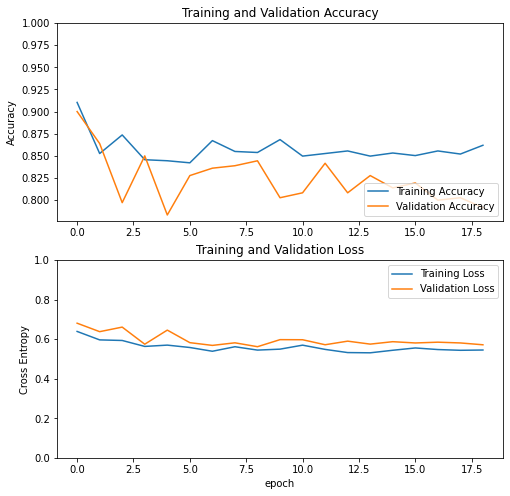

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [78]:
base_model.trainable = True

In [79]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  564


In [80]:
# Fine-tune from this layer onwards
fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [81]:
model.compile(#optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              loss_weights=[0.9, 0.1])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 223, 223, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 223, 223, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 223, 223, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               104908

In [82]:
fine_tune_epochs = 50
initial_epochs = 19
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[checkpoint_cb, reduceLR_cb, early_stopping_cb],
                         class_weight=class_weight)

Epoch 19/69
27/27 [==============================] - 180s 6s/step - loss: 0.5914 - accuracy: 0.8618 - val_loss: 0.7576 - val_accuracy: 0.5972
Epoch 20/69
27/27 [==============================] - 163s 6s/step - loss: 0.4892 - accuracy: 0.8636 - val_loss: 0.4615 - val_accuracy: 0.8611
Epoch 21/69
27/27 [==============================] - 163s 6s/step - loss: 0.4154 - accuracy: 0.8774 - val_loss: 0.3465 - val_accuracy: 0.8694
Epoch 22/69
27/27 [==============================] - 163s 6s/step - loss: 0.3142 - accuracy: 0.8917 - val_loss: 0.3220 - val_accuracy: 0.8833
Epoch 23/69
27/27 [==============================] - 163s 6s/step - loss: 0.2512 - accuracy: 0.9311 - val_loss: 0.2831 - val_accuracy: 0.9000
Epoch 24/69
27/27 [==============================] - 163s 6s/step - loss: 0.1856 - accuracy: 0.9369 - val_loss: 0.2688 - val_accuracy: 0.9000
Epoch 25/69
27/27 [==============================] - 163s 6s/step - loss: 0.1548 - accuracy: 0.9547 - val_loss: 0.2927 - val_accuracy: 0.9111
Epoch 

In [83]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

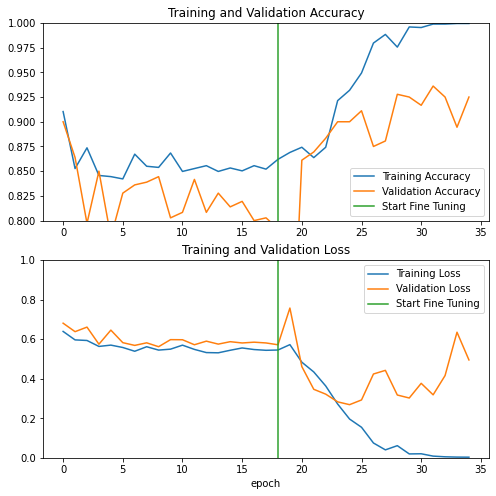

In [84]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/HACKATHON 2020/TRANSFER LEARNING/ResNet152V2_model_covid.h5')

In [85]:
# model evaluate with validation set
model.evaluate(validation_dataset)

6/6 [==============================] - 23s 3s/step - loss: 0.2631 - accuracy: 0.8972


[0.26309874653816223, 0.8972222208976746]

In [86]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 23s 3s/step - loss: 0.2638 - accuracy: 0.9036
Test accuracy : 0.9036458134651184


Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


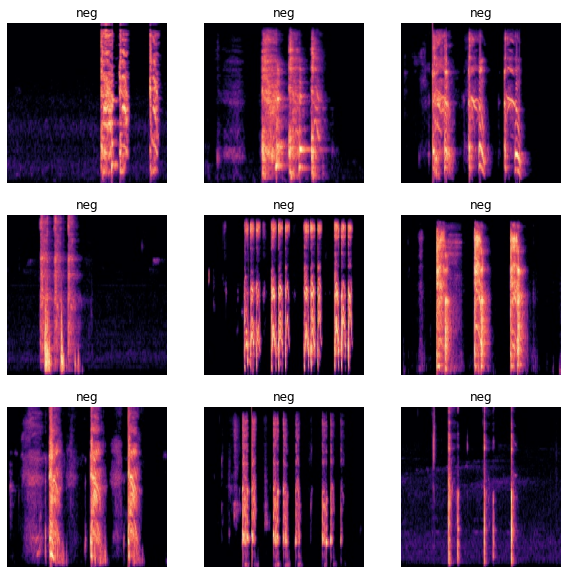

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
predictions = model.predict(test_dataset)
predictions = tf.nn.sigmoid(predictions) # Apply a sigmoid since our model returns logits
# predictions = tf.where(predictions < 0.5, 0, 1)

In [ ]:
def Confusion_Matrix(y_true, y_predicted, binarized_true = False, binarized_pred = False, pred_prob = False):

    '''
    Generate a confusion matrix for binary classification. Additionally plots the ROC and AUC if the
    output of the model predicts probabilities
    @params:
        y_true          - A list of integers or strings for known classes
        y_predicted     - A list of integers, strings or probabilities for predicted classes
        binaried_true   - If the y_true are strings (FALSE,TRUE) converts to numerical [0,1]
        binaried_pred   - If the y_predicted are strings (FALSE,TRUE) converts to numerical [0,1]
        pred_prob       - If the predictions of the model are probabilities, then an optimal threshold can be compute
                          as well as plotting the ROC and AUC

    @return:
        confusion matrix
        classification Report
        optimal threshold
        AUC
        Plot of ROC
        y_true, y_predicted   (treated)

    @ Precision: What proportion of positive identifications was actually correct?
                 Our model has a precision of 0.5—in other words, when it predicts a recording is a cough, it is correct 50% of the time.

    @ Recall: What proportion of actual positives was identified correctly?
              Our model has a recall of 0.11—in other words, it correctly identifies 11% of all cough recordings.
    '''
    import pandas as pd
    from sklearn.metrics import roc_curve, auc, classification_report

    y_true = pd.Series(y_true, name = 'Actual')
    y_predicted = pd.Series(y_predicted, name='Predicted')

    if (binarized_true):
        y_true = y_true.map({True:1, False:0})

    if (binarized_pred):
        y_predicted = y_predicted.map({True:1, False:0})

    if (pred_prob):
        fpr, tpr, thresholds = roc_curve(y_true, y_predicted, pos_label=1)
        roc_auc = auc(fpr, tpr)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        print("\n __________ \n")
        print("Optimal Threshold: {} \n __________ \n".format(round(optimal_threshold,4)))

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange',
                 label='ROC curve (area = {})'.format(round(roc_auc,3)))
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

        y_predicted = pd.Series(np.where(y_predicted>=optimal_threshold, 1, 0), name='Predicted')


    df_confusion = pd.crosstab(y_true, y_predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)

    print("\n __________ \n")
    print("Confusion Matrix: \n __________ \n")
    print(df_confusion)
    print("\n __________ \n")
    print("Classification Report: \n __________ \n")
    print(classification_report(y_true, y_predicted))

    return y_true, y_predicted

In [ ]:
import numpy as np

labels = []
predictions = []

for img, label in test_dataset:
    _predictions = model.predict_on_batch(img).flatten()
    _predictions = tf.nn.sigmoid(_predictions).numpy()

    for lab in label.numpy():
      labels.append(lab)

    for pred in _predictions:
      predictions.append(pred)

predictions = np.array(predictions)
labels = np.array(labels)

In [ ]:
print(predictions.shape)
print(labels.shape)

(320,)
(320,)


In [ ]:
'''
labels = []
predictions = []

#Retrieve a batch of images from the test set
for i in range(tf.data.experimental.cardinality(test_dataset).numpy()):
  image_batch, label_batch = test_dataset.as_numpy_iterator().next()
  _predictions = model.predict_on_batch(image_batch).flatten()
  #_predictions = tf.nn.sigmoid(predictions)

  for lab in label_batch:
    labels.append(lab)
  
  for pred in _predictions:
    predictions.append(pred)

'''


 __________ 

Optimal Threshold: 0.2500999867916107 
 __________ 



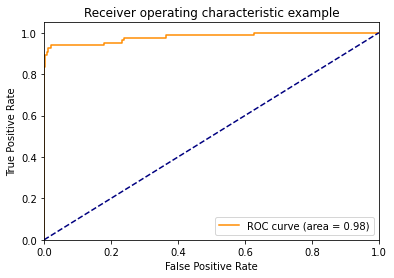


 __________ 

Confusion Matrix: 
 __________ 

Predicted    0   1  All
Actual                 
0          231   5  236
1            5  79   84
All        236  84  320

 __________ 

Classification Report: 
 __________ 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       236
           1       0.94      0.94      0.94        84

    accuracy                           0.97       320
   macro avg       0.96      0.96      0.96       320
weighted avg       0.97      0.97      0.97       320



In [ ]:
y_true, y_predicted = Confusion_Matrix(y_true = labels,
                                       y_predicted = predictions,
                                       pred_prob = True)